In [1]:
import pandas as pd

In [63]:
import pickle

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [40]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration >=1) & (df.duration <= 60)]

    categorical = ['PULocationID','DOLocationID']

    df[categorical] = df[categorical].astype(str)

    return df


In [41]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [42]:
print(len(df_train))
print(len(df_val))

73908
61921


In [53]:
df_train['PU-DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU-DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [54]:
df_val.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU-DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.0,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.5,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.5,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.0,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.5,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42


In [56]:
categorical = ['PU-DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [57]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [64]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [65]:
y_pred = lr.predict(X_val)

In [66]:
mean_squared_error(y_val,y_pred,squared=False)

7.758715200888857

In [67]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr), f_out)

In [61]:
lr = Lasso(alpha=0.001)
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val,y_pred,squared=False)

9.233436225720547

In [62]:
lr = Ridge()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val,y_pred,squared=False)

7.70373513366094

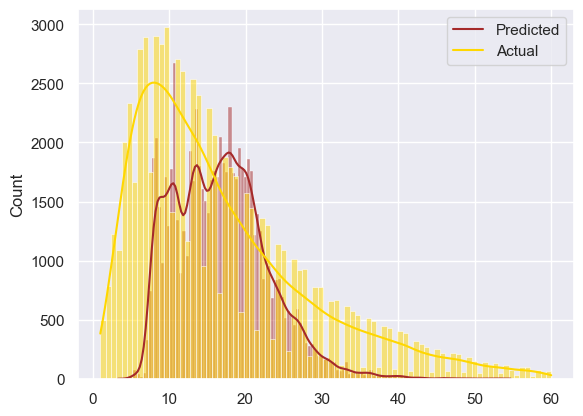

In [36]:
sns.set_theme(style='darkgrid')
sns.histplot(data=y_pred, kde=True,color='brown', fill=True)
sns.histplot(data=y_train, kde=True, color='gold', fill=True)

plt.legend(['Predicted','Actual'])